In [1]:
! mkdir ~/.kaggle

In [2]:
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle competitions download -c state-farm-distracted-driver-detection

100% 4.00G/4.00G [00:20<00:00, 257MB/s]
100% 4.00G/4.00G [00:20<00:00, 213MB/s]


In [5]:
! unzip /content/state-farm-distracted-driver-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: imgs/train/c7/img_56636.jpg  
  inflating: imgs/train/c7/img_56661.jpg  
  inflating: imgs/train/c7/img_56699.jpg  
  inflating: imgs/train/c7/img_56717.jpg  
  inflating: imgs/train/c7/img_56724.jpg  
  inflating: imgs/train/c7/img_56768.jpg  
  inflating: imgs/train/c7/img_56779.jpg  
  inflating: imgs/train/c7/img_56849.jpg  
  inflating: imgs/train/c7/img_56899.jpg  
  inflating: imgs/train/c7/img_56938.jpg  
  inflating: imgs/train/c7/img_5706.jpg  
  inflating: imgs/train/c7/img_57076.jpg  
  inflating: imgs/train/c7/img_57122.jpg  
  inflating: imgs/train/c7/img_57137.jpg  
  inflating: imgs/train/c7/img_5715.jpg  
  inflating: imgs/train/c7/img_57278.jpg  
  inflating: imgs/train/c7/img_57321.jpg  
  inflating: imgs/train/c7/img_57345.jpg  
  inflating: imgs/train/c7/img_57355.jpg  
  inflating: imgs/train/c7/img_5741.jpg  
  inflating: imgs/train/c7/img_57433.jpg  
  inflating: imgs/train/c7/img_5753.jpg  
  infla

#Import Libraries

In [6]:
#Files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob

#DATA
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

#CNN
from tensorflow.keras import layers
from keras import models 
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint

#VIS
from keras.utils.vis_utils import plot_model
from keras.preprocessing import image

#Preprocessing Data

In [7]:
def preparData(path):
  imagsList = []
  labels = []
  for dic in sorted(glob.glob(os.path.join(path,'*')), key = lambda k: k.split('/')[-1]):
    for imgs in glob.glob(os.path.join(dic, '*.jpg')):
      img = cv2.imread(imgs)
      img_r = cv2.resize(img,(128,128))
      imagsList.append(img_r)
      labels.append(int(dic.split("/")[-1].replace('c','')))
  
  X_train, X_test, y_train, y_test = train_test_split(imagsList, labels, test_size=0.2,shuffle= True, random_state = 0)
  y_train = to_categorical(y_train)
  y_test  = to_categorical(y_test)

  return np.array(X_train), np.array(X_test), y_train, y_test


#Get Data

In [8]:
path_train = "/content/imgs/train/"
path_test  = "/content/imgs/test/"

X_train, X_test, y_train, y_test = preparData(path_train)

print(f"Size X_train: {len(X_train)}, Size y_train: {len(y_train)}")
print(f"Size X_test: {len(X_test)}, Size y_test {len(y_test)}")

Size X_train: 17939, Size y_train: 17939
Size X_test: 4485, Size y_test 4485


#Load Model

In [9]:
from keras.models import load_model

model = load_model('/content/ConvNet_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 Pool_1 (MaxPooling2D)       (None, 62, 62, 32)        0         
                                                                 
 Conv_2 (Conv2D)             (None, 58, 58, 64)        51264     
                                                                 
 Pool_2 (MaxPooling2D)       (None, 29, 29, 64)        0         
                                                                 
 Conv_3 (Conv2D)             (None, 25, 25, 128)       204928    
                                                                 
 Pool_3 (MaxPooling2D)       (None, 12, 12, 128)       0         
                                                                 
 Conv_4 (Conv2D)             (None, 8, 8, 256)         8

#Load Image 

In [21]:
img_path = "/content/imgs/test/img_10001.jpg"

# We preprocess the image into a 4D tensor


img = image.load_img(img_path, target_size=(128, 128))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

img_tensor /= 255.

# Its shape is (1, 128, 128, 3)
print(img_tensor.shape)

(1, 128, 128, 3)


In [22]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

**Display Image**

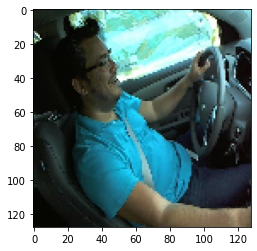

In [23]:
plt.imshow(img_tensor[0])
plt.show()

#Using model to predict Model

In [24]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

In [25]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 124, 124, 32)


#Visualizing the 3rd channel

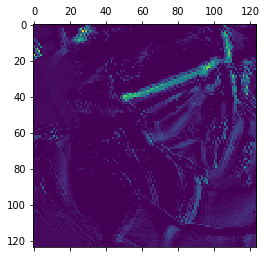

In [26]:
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

#visualizing the 30th channel

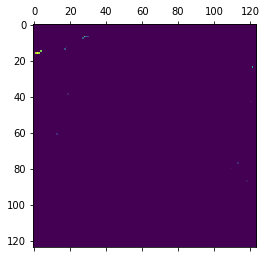

In [27]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

#Visualization of all the activations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


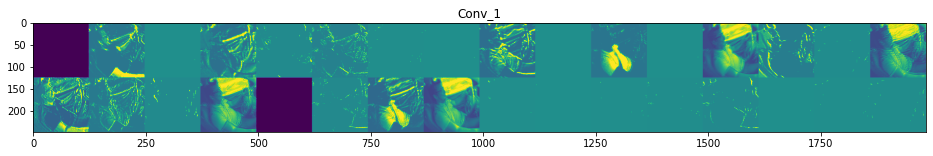

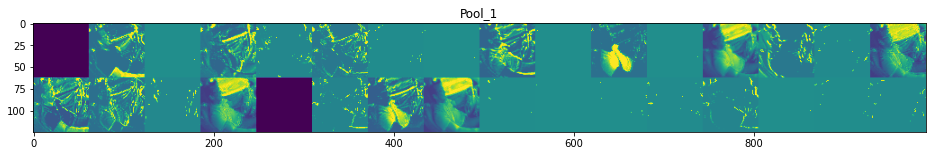

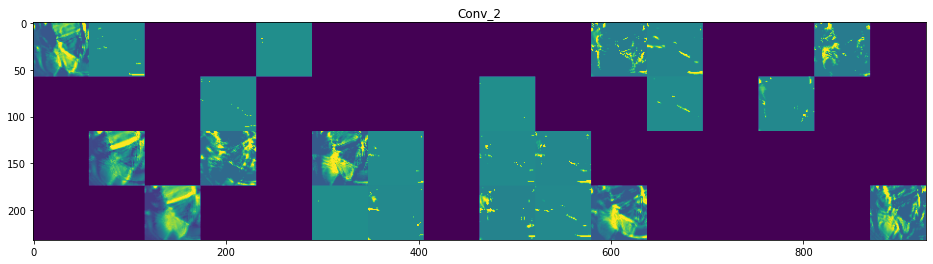

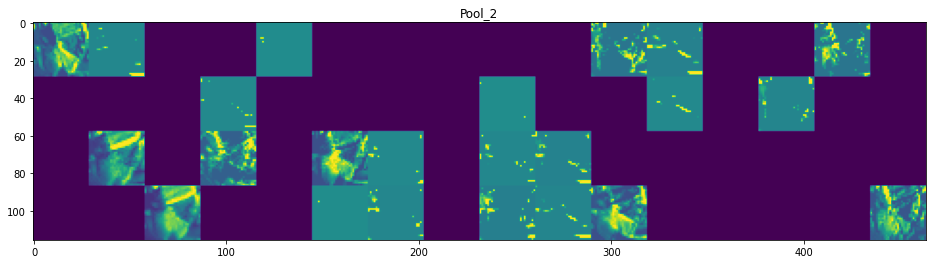

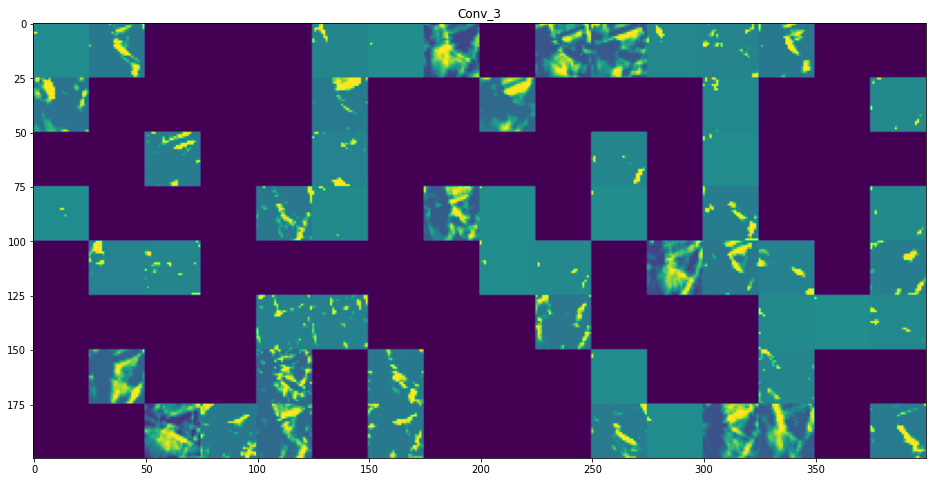

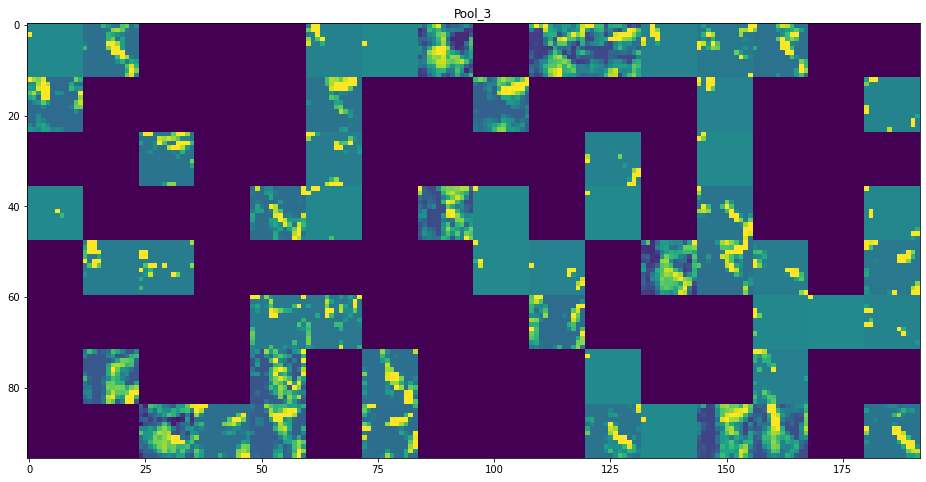

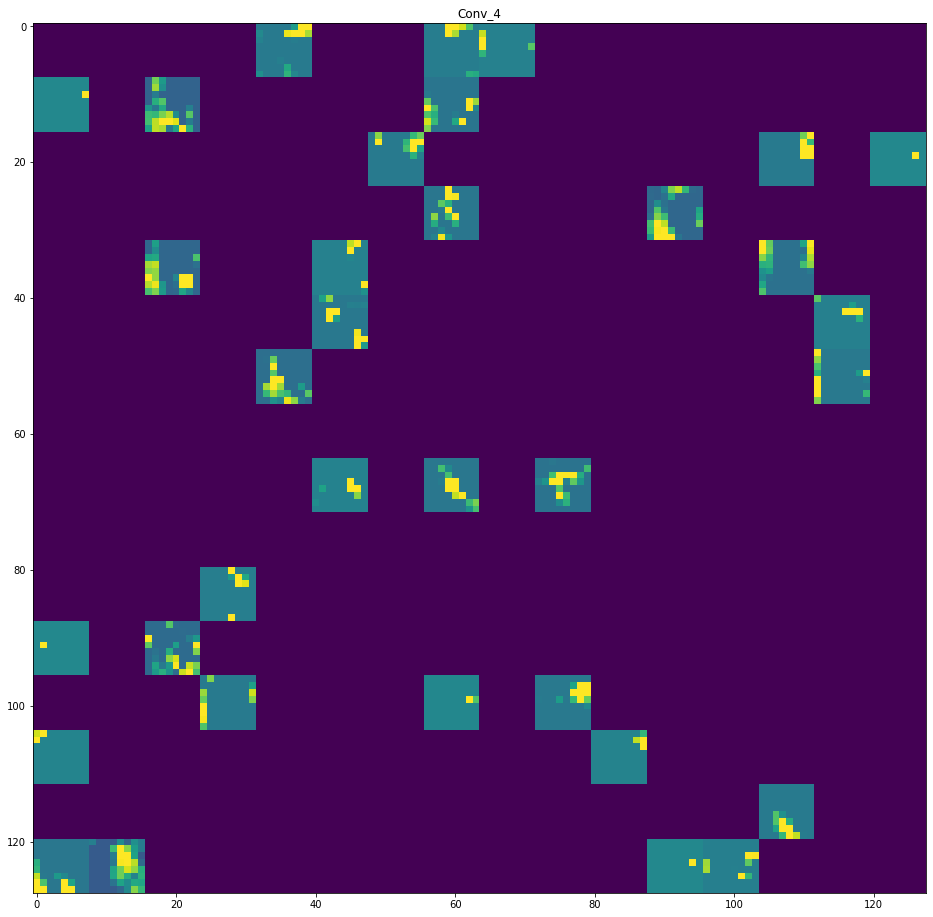

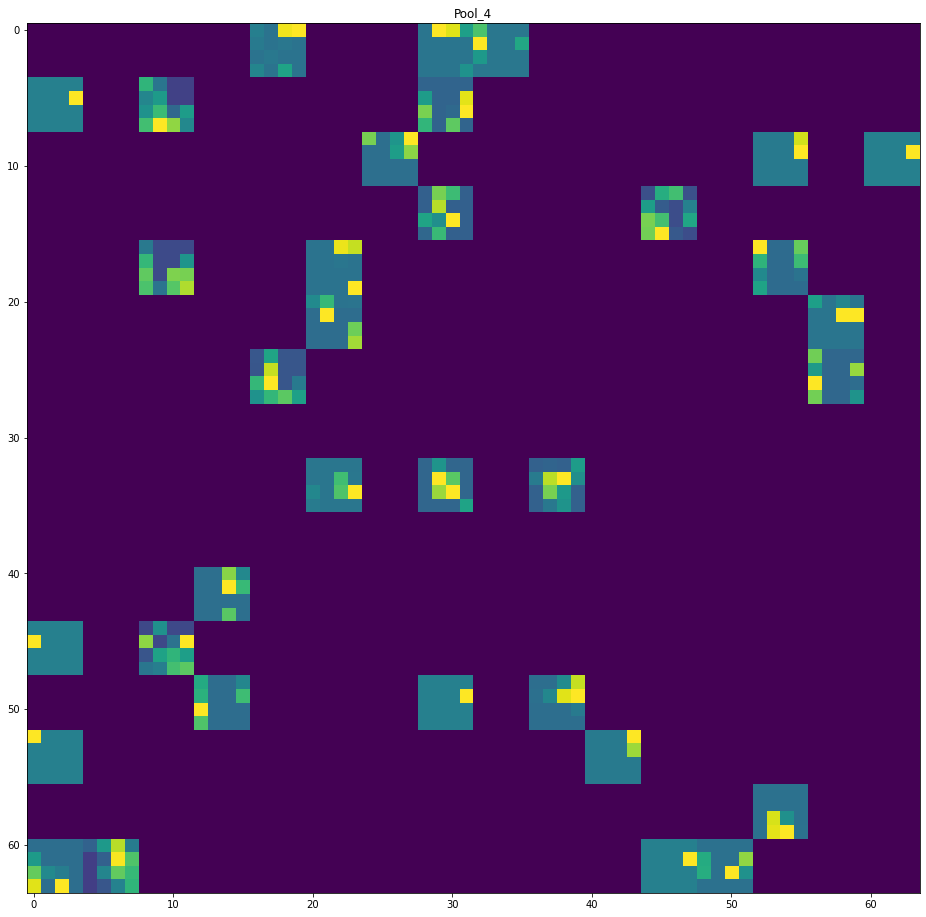

In [28]:
layer_names = []
for layer in model.layers[:]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()